In [12]:
#@title Load a video file from GoogleDrive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
#@title Install pytube
!pip install pytube

In [14]:
#@title Download youtube video
from pytube import YouTube
import uuid

#@markdown youtube 동영상의 videoid를 입력할 것
video_id = "FKj2AFly4o0" #@param {type:"string"}
video_url = "https://www.youtube.com/watch?v=" + video_id
#@markdown folder를 작성할 때 반드시 끝에 /를 작성할 것
video_folder = "/content/drive/MyDrive/Colab_sample_data/" #@param {type:"string"}
audio_folder = "/content/drive/MyDrive/Colab_sample_data/" #@param {type:"string"}
video_name = video_id
video_path = video_folder+video_name+".mp4"
audio_path = audio_folder+video_name+".wav"
#@markdown "https://www.google.com/device" 에서 코드 입력해야 함
yt = YouTube(video_url, use_oauth=True, allow_oauth_cache=True)
yt.title = video_name
clip = yt.streams.get_highest_resolution() # 고화질 설정
clip.download(video_folder)

'/content/drive/MyDrive/Colab_sample_data/FKj2AFly4o0.mp4'

In [15]:
#@title Install ffmpeg
!sudo apt install ffmpeg

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 33 not upgraded.


In [16]:
#@title Format change video to wav
import os
os.system(f"ffmpeg -i \"{video_path}\" -ac 2 -f wav \"{audio_path}\"")

0

In [17]:
#@title Install laughter-detection
!git clone https://github.com/jrgillick/laughter-detection.git
%cd laughter-detection/
!pip install librosa==0.9.2
!pip install tgt
!pip install pyloudnorm
!pip install praatio==3.8.0
!pip install tensorboardX==1.9

from google.colab import files

Cloning into 'laughter-detection'...
remote: Enumerating objects: 432, done.
remote: Total 432 (delta 0), reused 0 (delta 0), pack-reused 432
Receiving objects: 100% (432/432), 85.84 MiB | 15.82 MiB/s, done.
Resolving deltas: 100% (233/233), done.
/content/laughter-detection/laughter-detection


In [18]:
#@title Setup and Load Model

import os, sys, pickle, time, librosa, argparse, torch, numpy as np, pandas as pd, scipy
from tqdm import tqdm
import tgt
sys.path.append('./utils/')
import laugh_segmenter
import models, configs
import dataset_utils, audio_utils, data_loaders, torch_utils
from tqdm import tqdm
from torch import optim, nn
from functools import partial
from distutils.util import strtobool

sample_rate = 8000

model_path = 'checkpoints/in_use/resnet_with_augmentation'
config = configs.CONFIG_MAP['resnet_with_augmentation']

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device {device}")

##### Load the Model

model = config['model'](dropout_rate=0.0, linear_layer_size=config['linear_layer_size'], filter_sizes=config['filter_sizes'])
feature_fn = config['feature_fn']
model.set_device(device)

if os.path.exists(model_path):
    torch_utils.load_checkpoint(model_path+'/best.pth.tar', model)
    model.eval()
else:
    raise Exception(f"Model checkpoint not found at {model_path}")

Using device cuda
training with dropout=0.0
Loading checkpoint at: checkpoints/in_use/resnet_with_augmentation/best.pth.tar
Loading checkpoint at step:  60600


In [19]:
#@title Choose settings and run Laughter Detection

#@markdown This will take a minute
output_dir = 'laughter_detection_output' #@param {type:"string"}
threshold = 0.5 #@param {type:"slider", min:0.1, max:1.0, step:0.1}
min_length = 0.2 #@param {type:"slider", min:0.1, max:1.0, step:0.1}
save_to_audio_files = True #@param {type:"boolean"}


##### Load the audio file and features

inference_dataset = data_loaders.SwitchBoardLaughterInferenceDataset(
    audio_path=audio_path, feature_fn=feature_fn, sr=sample_rate)

collate_fn=partial(audio_utils.pad_sequences_with_labels,
                        expand_channel_dim=config['expand_channel_dim'])

inference_generator = torch.utils.data.DataLoader(
    inference_dataset, num_workers=4, batch_size=8, shuffle=False, collate_fn=collate_fn)


##### Make Predictions

probs = []
for model_inputs, _ in tqdm(inference_generator):
    x = torch.from_numpy(model_inputs).float().to(device)
    preds = model(x).cpu().detach().numpy().squeeze()
    if len(preds.shape)==0:
        preds = [float(preds)]
    else:
        preds = list(preds)
    probs += preds
probs = np.array(probs)

file_length = audio_utils.get_audio_length(audio_path)

fps = len(probs)/float(file_length)

probs = laugh_segmenter.lowpass(probs)
instances = laugh_segmenter.get_laughter_instances(probs, threshold=threshold, min_length=float(min_length), fps=fps)

print(); print("found %d laughs." % (len (instances)))

if len(instances) > 0:
    full_res_y, full_res_sr = librosa.load(audio_path,sr=44100)
    wav_paths = []
    maxv = np.iinfo(np.int16).max

    if save_to_audio_files:
        if output_dir is None:
            raise Exception("Need to specify an output directory to save audio files")
        else:
            os.system(f"mkdir -p {output_dir}")
            for index, instance in enumerate(instances):
                laughs = laugh_segmenter.cut_laughter_segments([instance],full_res_y,full_res_sr)
                wav_path = output_dir + "/laugh_" + str(index) + ".wav"
                scipy.io.wavfile.write(wav_path, full_res_sr, (laughs * maxv).astype(np.int16))
                wav_paths.append(wav_path)
            print(laugh_segmenter.format_outputs(instances, wav_paths))

/content/laughter-detection/./utils/audio_utils.py:228: FutureWarning: Pass y=[ 0.          0.          0.         ... -0.00291648 -0.0016849
  0.        ], sr=8000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  S = librosa.feature.melspectrogram(y, sr, hop_length=hop_length).T
100%|██████████| 43646/43646 [09:24<00:00, 77.37it/s]



found 447 laughs.
[{'filename': 'laughter_detection_output/laugh_0.wav', 'start': 305.42648836402225, 'end': 308.4493618689574}, {'filename': 'laughter_detection_output/laugh_1.wav', 'start': 314.1230629089895, 'end': 320.2385685382044}, {'filename': 'laughter_detection_output/laugh_2.wav', 'start': 323.4242121549437, 'end': 325.9122695782365}, {'filename': 'laughter_detection_output/laugh_3.wav', 'start': 327.05166036086587, 'end': 329.7722465153075}, {'filename': 'laughter_detection_output/laugh_4.wav', 'start': 335.143660204846, 'end': 341.44518881898006}, {'filename': 'laughter_detection_output/laugh_5.wav', 'start': 344.3983037045705, 'end': 346.3515450462209}, {'filename': 'laughter_detection_output/laugh_6.wav', 'start': 347.4909358288503, 'end': 348.4210507534457}, {'filename': 'laughter_detection_output/laugh_7.wav', 'start': 352.7693380259293, 'end': 354.49005063643085}, {'filename': 'laughter_detection_output/laugh_8.wav', 'start': 375.95245252147026, 'end': 401.97241753702

In [20]:
#@title Laugh Video Setting
import math
audio_total_length = math.floor(librosa.get_duration(y=full_res_y, sr=full_res_sr))
audio_laugh_check = [False] * (audio_total_length+1)

for item in laugh_segmenter.format_outputs(instances, wav_paths):
  strsec = math.floor(item["start"])
  endsec = math.floor(item["end"])
  for sec in range(strsec, endsec+1):
    audio_laugh_check[sec] = True

laugh_length = 120 #@param {type:"number"}

laughCnt = 0
left, right = 0, laugh_length
for index in range(left, right):
  if(audio_laugh_check[index]): laughCnt+=1

x_values = [0]
y_values = [laughCnt]
while(right < audio_total_length):
  if(audio_laugh_check[left]): laughCnt -= 1
  if(audio_laugh_check[right+1]): laughCnt += 1
  left, right = left+1, right+1
  x_values.append(left)
  y_values.append(laughCnt)


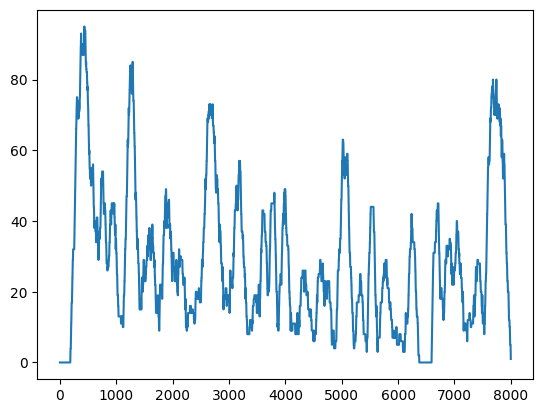

In [21]:
#@title Laugh Moment Graph
import matplotlib.pyplot as plt
plt.plot(x_values, y_values)
plt.show()

In [22]:
#@title get Best Laugh Clips
clip_num = 3 #@param {type:"number"}
laugh_before = 30 #@param {type:"number"}
laugh_after = 30 #@param {type:"number"}
clip_total_length = laugh_before + laugh_length + laugh_after

copy_x = x_values.copy()
copy_y = y_values.copy()

for num in range(0, clip_num):
  index = copy_y.index(max(copy_y))
  str_time = max(0, index-laugh_before)
  end_time = min(index+laugh_length+laugh_after, audio_total_length)
  left = max(0, index-clip_total_length)
  right = min(index+clip_total_length, audio_total_length)
  copy_x = copy_x[0:left] + copy_x[right:audio_total_length]
  copy_y = copy_y[0:left] + copy_y[right:audio_total_length]

  clip_path = video_folder + video_name + "_clip" + str(num) + ".mp4"
  print(f"ffmpeg -i {video_path} -ss {str_time} -to {end_time} -c:v copy -c:a copy {clip_path}")
  os.system(f"ffmpeg -i {video_path} -ss {str_time} -to {end_time} -c:v copy -c:a copy {clip_path}")

ffmpeg -i /content/drive/MyDrive/Colab_sample_data/FKj2AFly4o0.mp4 -ss 403 -to 583 -c:v copy -c:a copy /content/drive/MyDrive/Colab_sample_data/FKj2AFly4o0_clip0.mp4
ffmpeg -i /content/drive/MyDrive/Colab_sample_data/FKj2AFly4o0.mp4 -ss 900 -to 1080 -c:v copy -c:a copy /content/drive/MyDrive/Colab_sample_data/FKj2AFly4o0_clip1.mp4
ffmpeg -i /content/drive/MyDrive/Colab_sample_data/FKj2AFly4o0.mp4 -ss 6932 -to 7112 -c:v copy -c:a copy /content/drive/MyDrive/Colab_sample_data/FKj2AFly4o0_clip2.mp4
